# Vaccination Rates and Socioeconomic Status in BC

### Project authors:

### Created on: October 25, 2021

### Last modified on: October 25, 2021

## Import libraries

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.preprocessing import OrdinalEncoder
import scipy as sp
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import ResidualsPlot

In [39]:
# load dataframes
modelling_df = pd.read_csv('../data/socioeco_compiled.csv')
vaccine_df = pd.read_csv('../data/BCCDC_COVID19_CHSA_Data_NHA.csv')
modelling_df.columns

Index(['m_0_4', 'm_5_9', 'm_10_14', 'm_15_19', 'm_20_24', 'm_25_29', 'm_30_34',
       'm_35_39', 'm_40_44', 'm_45_49',
       ...
       'rheumatoid_arthritis_age_standardized_prevalence_per_100',
       'schizophrenia_incidence_per_1000', 'schizophrenia_prevalence_per_100',
       'schizophrenia_age_standardized_incidence_per_1000',
       'schizophrenia_age_standardized_prevalence_per_100', 'hsa', 'subregion',
       'proportion_has_GP_practitioner.1', 'proportion_has_GP_practice.1',
       'code'],
      dtype='object', length=207)

In [40]:
# subset dataframes
modelling_df = modelling_df[['code','percent_dwellings_need_repairs','percent_detached_houses',
'situational_vulnerability', 'ethnocultural_composition', 'economic_dependency', 'residential_instability', 
'percent_aboriginal', 'percent_chinese', 'percent_filipino', 'percent_white',
'percent_immigrant', 'percent_no_eng_fra', 'percent_less_than_high_school', 'employment_rate', 'low_income_prevalence',
'percent_postsecondary', 'proportion_has_GP_practice','hsa']]
vaccine_df = vaccine_df[['CHSA18_Code','D1_12_coverage']]
vaccine_df.columns = ['code', 'D1_12_coverage']

# merge dataframes
m_df = pd.merge(modelling_df, vaccine_df, how = 'inner', on="code")
print(len(m_df))
m_df.head()

151


,code,percent_dwellings_need_repairs,percent_detached_houses,situational_vulnerability,ethnocultural_composition,economic_dependency,residential_instability,percent_aboriginal,percent_chinese,percent_filipino,percent_white,percent_immigrant,percent_no_eng_fra,percent_less_than_high_school,employment_rate,low_income_prevalence,percent_postsecondary,proportion_has_GP_practice,hsa,D1_12_coverage
0,3112,5.4%,60.7%,3.0,5.0,4.0,2.0,0.6%,65.4%,4.2%,18.5%,65.4%,13.3%,13.0%,49.5%,24.5%,55.9%,79.7%,Vancouver Coastal Health,84.0
1,3223,10.6%,8.5%,4.0,4.0,1.0,5.0,7.8%,13.4%,3.0%,64.2%,26.6%,4.3%,14.0%,69.9%,20.5%,62.6%,74.5%,Vancouver Coastal Health,89.0
2,3115,4.6%,48.7%,2.0,5.0,3.0,2.0,1.6%,30.9%,5.3%,46.8%,40.4%,4.4%,10.4%,60.0%,12.4%,62.3%,83.9%,Vancouver Coastal Health,90.0
3,3261,7.2%,16.4%,4.0,5.0,3.0,4.0,1.5%,40.2%,8.9%,27.0%,52.2%,9.1%,16.6%,59.2%,17.1%,54.3%,80.5%,Vancouver Coastal Health,92.0
4,3312,6.2%,6.3%,2.0,5.0,1.0,5.0,3.8%,4.2%,6.6%,62.7%,41.4%,1.8%,8.5%,65.8%,18.7%,67.7%,75.0%,Vancouver Coastal Health,91.0


In [41]:
# remove percent signs
m_df = m_df.replace({'%':''}, regex = True)
m_df = m_df.drop(['code'], axis = 1)
# one hot encode hsa
one_hot = pd.get_dummies(m_df['hsa'])
m_df = m_df.drop('hsa', axis = 1)
m_df = m_df.join(one_hot)


In [42]:
m_df.isna().sum()

percent_dwellings_need_repairs    0
percent_detached_houses           0
situational_vulnerability         3
ethnocultural_composition         3
economic_dependency               3
residential_instability           3
percent_aboriginal                0
percent_chinese                   0
percent_filipino                  0
percent_white                     0
percent_immigrant                 0
percent_no_eng_fra                0
percent_less_than_high_school     0
employment_rate                   0
low_income_prevalence             0
percent_postsecondary             0
proportion_has_GP_practice        0
D1_12_coverage                    0
Fraser Health                     0
Interior Health                   0
Island Health                     0
Northern Health                   0
Vancouver Coastal Health          0
dtype: int64

In [43]:
# remove rows with NAs
m_df = m_df.dropna()
# normalize the data
trans = MinMaxScaler()
'''
m_df.iloc[:, m_df.columns.isin(list(['percent_dwellings_need_repairs', 'percent_detached_houses',
       'percent_aboriginal','percent_chinese', 'percent_filipino', 'percent_white','percent_immigrant', 'percent_no_eng_fra',
       'percent_less_than_high_school', 'employment_rate']))] = trans.fit_transform(m_df.iloc[:, m_df.columns.isin(list(['percent_dwellings_need_repairs', 'percent_detached_houses',
       'percent_aboriginal','percent_chinese', 'percent_filipino', 'percent_white','percent_immigrant', 'percent_no_eng_fra',
       'percent_less_than_high_school', 'employment_rate']))])
'''
X = m_df.drop(columns=['D1_12_coverage']).values
# X = m_df.iloc[:, :-1].values
y = m_df.iloc[:, -6].values


# split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)
# instantiate the regressor and train
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
m_df.head()


,percent_dwellings_need_repairs,percent_detached_houses,situational_vulnerability,ethnocultural_composition,economic_dependency,residential_instability,percent_aboriginal,percent_chinese,percent_filipino,percent_white,...,employment_rate,low_income_prevalence,percent_postsecondary,proportion_has_GP_practice,D1_12_coverage,Fraser Health,Interior Health,Island Health,Northern Health,Vancouver Coastal Health
0,5.4,60.7,3.0,5.0,4.0,2.0,0.6,65.4,4.2,18.5,...,49.5,24.5,55.9,79.7,84.0,0,0,0,0,1
1,10.6,8.5,4.0,4.0,1.0,5.0,7.8,13.4,3.0,64.2,...,69.9,20.5,62.6,74.5,89.0,0,0,0,0,1
2,4.6,48.7,2.0,5.0,3.0,2.0,1.6,30.9,5.3,46.8,...,60.0,12.4,62.3,83.9,90.0,0,0,0,0,1
3,7.2,16.4,4.0,5.0,3.0,4.0,1.5,40.2,8.9,27.0,...,59.2,17.1,54.3,80.5,92.0,0,0,0,0,1
4,6.2,6.3,2.0,5.0,1.0,5.0,3.8,4.2,6.6,62.7,...,65.8,18.7,67.7,75.0,91.0,0,0,0,0,1


0.5554200515922183
Feature: 0, Score: 0.09946
Feature: 1, Score: -0.08441
Feature: 2, Score: 0.41273
Feature: 3, Score: -0.81096
Feature: 4, Score: -0.36714
Feature: 5, Score: -0.57077
Feature: 6, Score: -0.11087
Feature: 7, Score: -0.26183
Feature: 8, Score: -0.08818
Feature: 9, Score: -0.25594
Feature: 10, Score: -0.12363
Feature: 11, Score: 0.64628
Feature: 12, Score: -0.97982
Feature: 13, Score: -0.17755
Feature: 14, Score: -0.16604
Feature: 15, Score: -0.01263
Feature: 16, Score: 0.14263
Feature: 17, Score: 0.84208
Feature: 18, Score: -0.64940
Feature: 19, Score: 4.43945
Feature: 20, Score: -5.99825
Feature: 21, Score: 1.36612


([<matplotlib.axis.XTick at 0x7ffbfa420550>,
 [Text(0, 0, 'percent_dwellings_need_repairs'),
  Text(1, 0, 'percent_detached_houses'),
  Text(2, 0, 'situational_vulnerability'),
  Text(3, 0, 'ethnocultural_composition'),
  Text(4, 0, 'economic_dependency'),
  Text(5, 0, 'residential_instability'),
  Text(6, 0, 'percent_aboriginal'),
  Text(7, 0, 'percent_chinese'),
  Text(8, 0, 'percent_filipino'),
  Text(9, 0, 'percent_white'),
  Text(10, 0, 'percent_immigrant'),
  Text(11, 0, 'percent_no_eng_fra'),
  Text(12, 0, 'percent_less_than_high_school'),
  Text(13, 0, 'employment_rate'),
  Text(14, 0, 'low_income_prevalence'),
  Text(15, 0, 'percent_postsecondary'),
  Text(16, 0, 'proportion_has_GP_practice'),
  Text(17, 0, 'Fraser Health'),
  Text(18, 0, 'Interior Health'),
  Text(19, 0, 'Island Health'),
  Text(20, 0, 'Northern Health'),
  Text(21, 0, 'Vancouver Coastal Health')])

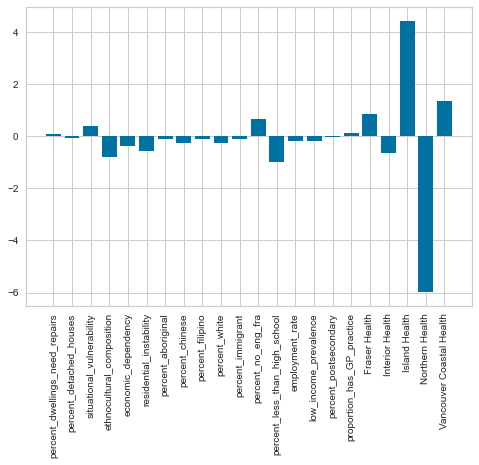

In [44]:
r2 = r2_score(y_test, y_pred)
print(r2)
# get importance
importance = regressor.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
labels = list(m_df.drop(columns=['D1_12_coverage']).columns)
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([x for x in range(len(importance))], labels, rotation = 'vertical')

So the biggest driver of this model is health authority, with Northern Health being the most strongly correlated.

Let's drop the health authority columns - they're a proxy for other factors.

In [11]:
print(m_df.drop(columns=['D1_12_coverage', 'Fraser Health', 'Interior Health', 'Northern Health', 'Island Health', 'Vancouver Coastal Health']).columns)

Index(['percent_dwellings_need_repairs', 'percent_detached_houses',
       'situational_vulnerability', 'ethnocultural_composition',
       'economic_dependency', 'residential_instability', 'percent_aboriginal',
       'percent_chinese', 'percent_filipino', 'percent_white',
       'percent_immigrant', 'percent_no_eng_fra',
       'percent_less_than_high_school', 'employment_rate',
       'low_income_prevalence', 'percent_postsecondary',
       'proportion_has_GP_practice'],
      dtype='object')


In [37]:
X = m_df.drop(columns=['D1_12_coverage', 'Fraser Health', 'Interior Health', 'Northern Health', 'Island Health', 'Vancouver Coastal Health']).values
# X = m_df.iloc[:, :-1].values
y = m_df.iloc[:, -6].values


# split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)
# instantiate the regressor and train
regressor2 = LinearRegression()
regressor2.fit(X_train, y_train)
y_pred = regressor2.predict(X_test)

0.5804849994669887
Feature: 0, Score: -0.06394
Feature: 1, Score: -0.10291
Feature: 2, Score: 0.51282
Feature: 3, Score: -0.36202
Feature: 4, Score: 0.61268
Feature: 5, Score: -0.79638
Feature: 6, Score: -0.29889
Feature: 7, Score: -0.32477
Feature: 8, Score: 0.12421
Feature: 9, Score: -0.23087
Feature: 10, Score: -0.20061
Feature: 11, Score: 1.03622
Feature: 12, Score: -1.08218
Feature: 13, Score: -0.17078
Feature: 14, Score: -0.15989
Feature: 15, Score: 0.06499
Feature: 16, Score: 0.13764


([<matplotlib.axis.XTick at 0x7ffbfad377c0>,
 [Text(0, 0, 'percent_dwellings_need_repairs'),
  Text(1, 0, 'percent_detached_houses'),
  Text(2, 0, 'situational_vulnerability'),
  Text(3, 0, 'ethnocultural_composition'),
  Text(4, 0, 'economic_dependency'),
  Text(5, 0, 'residential_instability'),
  Text(6, 0, 'percent_aboriginal'),
  Text(7, 0, 'percent_chinese'),
  Text(8, 0, 'percent_filipino'),
  Text(9, 0, 'percent_white'),
  Text(10, 0, 'percent_immigrant'),
  Text(11, 0, 'percent_no_eng_fra'),
  Text(12, 0, 'percent_less_than_high_school'),
  Text(13, 0, 'employment_rate'),
  Text(14, 0, 'low_income_prevalence'),
  Text(15, 0, 'percent_postsecondary'),
  Text(16, 0, 'proportion_has_GP_practice')])

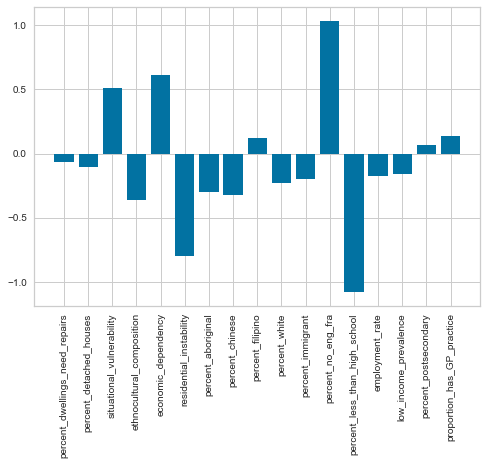

In [38]:
r2 = r2_score(y_test, y_pred)
print(r2)
# get importance
importance = regressor2.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
labels = list(m_df.drop(columns=['D1_12_coverage', 'Fraser Health', 'Interior Health', 'Northern Health', 'Island Health', 'Vancouver Coastal Health']).columns)
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([x for x in range(len(importance))], labels, rotation = 'vertical')

That's an even better R2 score. Let's drop all columns with a score of <|0.2|.

In [46]:
print(m_df.drop(columns=['D1_12_coverage', 'Fraser Health', 'Interior Health', 'Northern Health', 'Island Health', 'Vancouver Coastal Health', 
'percent_dwellings_need_repairs','percent_detached_houses', 'percent_filipino', 'employment_rate', 'low_income_prevalence', 'percent_postsecondary', 
'proportion_has_GP_practice']).columns)

Index(['situational_vulnerability', 'ethnocultural_composition',
       'economic_dependency', 'residential_instability', 'percent_aboriginal',
       'percent_chinese', 'percent_white', 'percent_immigrant',
       'percent_no_eng_fra', 'percent_less_than_high_school'],
      dtype='object')


In [47]:
X = m_df.drop(columns=['D1_12_coverage', 'Fraser Health', 'Interior Health', 'Northern Health', 'Island Health', 'Vancouver Coastal Health', 
'percent_dwellings_need_repairs','percent_detached_houses', 'percent_filipino', 'employment_rate', 'low_income_prevalence', 'percent_postsecondary', 
'proportion_has_GP_practice']).values
# X = m_df.iloc[:, :-1].values
y = m_df.iloc[:, -6].values


# split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)
# instantiate the regressor and train
regressor3 = LinearRegression()
regressor3.fit(X_train, y_train)
y_pred = regressor3.predict(X_test)

0.4816547279214809
Feature: 0, Score: 0.16739
Feature: 1, Score: -0.45208
Feature: 2, Score: 0.57180
Feature: 3, Score: -0.20456
Feature: 4, Score: -0.38484
Feature: 5, Score: -0.36137
Feature: 6, Score: -0.25287
Feature: 7, Score: -0.14600
Feature: 8, Score: 1.05168
Feature: 9, Score: -1.13398


([<matplotlib.axis.XTick at 0x7ffbfaf915b0>,
 [Text(0, 0, 'situational_vulnerability'),
  Text(1, 0, 'ethnocultural_composition'),
  Text(2, 0, 'economic_dependency'),
  Text(3, 0, 'residential_instability'),
  Text(4, 0, 'percent_aboriginal'),
  Text(5, 0, 'percent_chinese'),
  Text(6, 0, 'percent_white'),
  Text(7, 0, 'percent_immigrant'),
  Text(8, 0, 'percent_no_eng_fra'),
  Text(9, 0, 'percent_less_than_high_school')])

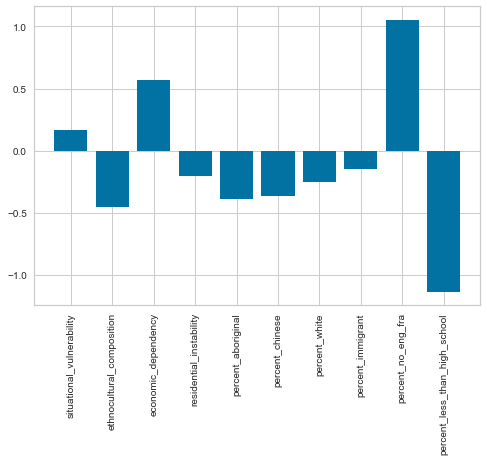

In [49]:
r2 = r2_score(y_test, y_pred)
print(r2)
# get importance
importance = regressor3.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
labels = list(m_df.drop(columns=['D1_12_coverage', 'Fraser Health', 'Interior Health', 'Northern Health', 'Island Health', 'Vancouver Coastal Health', 
'percent_dwellings_need_repairs','percent_detached_houses', 'percent_filipino', 'employment_rate', 'low_income_prevalence', 'percent_postsecondary', 
'proportion_has_GP_practice']).columns)
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([x for x in range(len(importance))], labels, rotation = 'vertical')

Let's try keeping only the features with a score >|0.5|.

In [50]:
X = m_df.iloc[:, m_df.columns.isin(list(['economic_dependency', 'percent_no_eng_fra', 
'percent_less_than_high_school']))].values
y = m_df.iloc[:, -6].values


0.5373971359872011
Feature: 0, Score: -0.23700
Feature: 1, Score: 0.82650
Feature: 2, Score: -0.88437


([<matplotlib.axis.XTick at 0x7ffbfac05bb0>,
 [Text(0, 0, 'economic_dependency'),
  Text(1, 0, 'percent_no_eng_fra'),
  Text(2, 0, 'percent_less_than_high_school')])

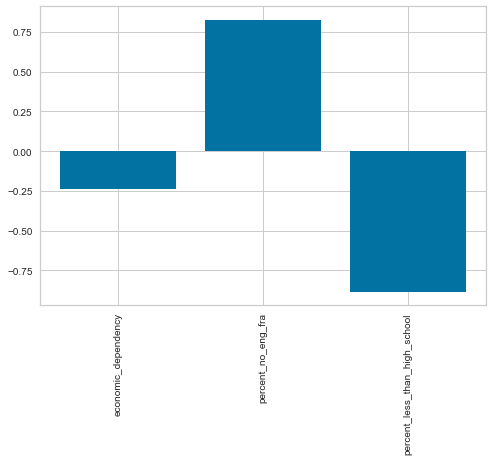

In [51]:
# split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)
# instantiate the regressor and train
regressor4 = LinearRegression()
regressor4.fit(X_train, y_train)
y_pred = regressor4.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(r2)
# get importance
importance = regressor4.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
labels = ['economic_dependency', 'percent_no_eng_fra', 'percent_less_than_high_school']
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([x for x in range(len(importance))], labels, rotation = 'vertical')

This 3-variable model is most strongly correlated with education and not speaking French or English.

0.5373971359872011

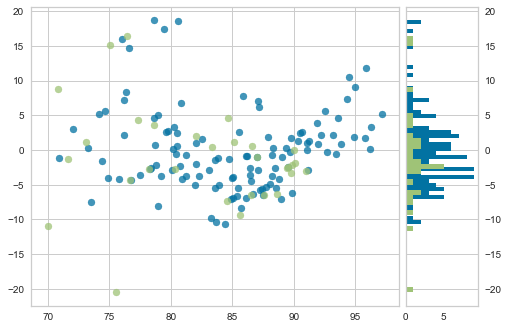

In [52]:
model = LinearRegression()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
#visualizer.show()                 # Finalize and render the figure

The residuals look pretty evenly distributed.

In [51]:
X = m_df.iloc[:, m_df.columns.isin(list(['percent_no_eng_fra', 
'percent_less_than_high_school']))].values
y = m_df.iloc[:, -1].values